# Detector de Carros com Transformada de Hough (sem redes neurais)

Este notebook demonstra um exemplo simplificado de detecção de carros usando técnicas de processamento de imagem
como edge detection e transformadas de Hough para retas e círculos, sem uso de redes neurais.

Ao final, comparamos os pontos detectados com as coordenadas salvas em JSON/TXT, para verificar se os pontos
estão dentro da área marcada manualmente como o carro.

As imagens são carregadas de '/imagens', e os arquivos de coordenadas (TXT e JSON) são lidos de '/coordenadas'.


## 1. Importação de Bibliotecas

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature
from skimage.transform import hough_line, hough_line_peaks, hough_circle
from skimage.draw import circle_perimeter
from math import sqrt

## 2. Funções Auxiliares

In [2]:
def carrega_coordenadas(arquivo_txt, arquivo_json):
    """
    Tenta carregar tanto o TXT quanto o JSON com as coordenadas de um carro
    (Retângulo). Se o JSON existir, a leitura é feita a partir dele.
    Caso não exista, tenta o TXT.

    Retorna uma lista de vértices (x, y) do retângulo.
    """
    if os.path.exists(arquivo_json):
        with open(arquivo_json, "r") as f:
            return json.load(f)
    elif os.path.exists(arquivo_txt):
        coords = []
        with open(arquivo_txt, "r") as f:
            for linha in f:
                linha = linha.strip()
                if linha:
                    x_str, y_str = linha.split(",")
                    coords.append((float(x_str), float(y_str)))
        return coords
    else:
        return []

In [3]:
def dentro_do_retangulo(x, y, coords):
    """
    Verifica se o ponto (x, y) está dentro do retângulo definido pelos 4 vértices em coords.
    Aqui, assumimos que coords são 4 pontos de um retângulo:
    [ (x1, y1), (x1, y2), (x2, y1), (x2, y2) ] ou estrutura similar.
    Fazemos um min/max e verificamos se x,y está nesse intervalo.
    """
    if len(coords) < 4:
        return False
    xs = [p[0] for p in coords]
    ys = [p[1] for p in coords]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    return (min_x <= x <= max_x) and (min_y <= y <= max_y)

## 3. Detecção de Carros (Exemplo Simplificado)

Nesta etapa, carregamos cada imagem, aplicamos detecção de bordas (Canny),
e em seguida aplicamos as transformadas de Hough para detectar as linhas e possíveis círculos (ex.: pneus).
Este exemplo é apenas ilustrativo para mostrar como poderíamos tentar localizar padrões do carro.


Processando image_0001.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


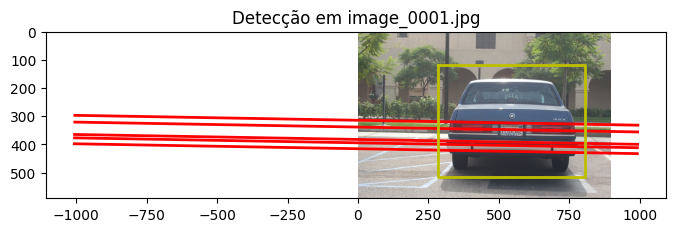


Processando image_0002.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


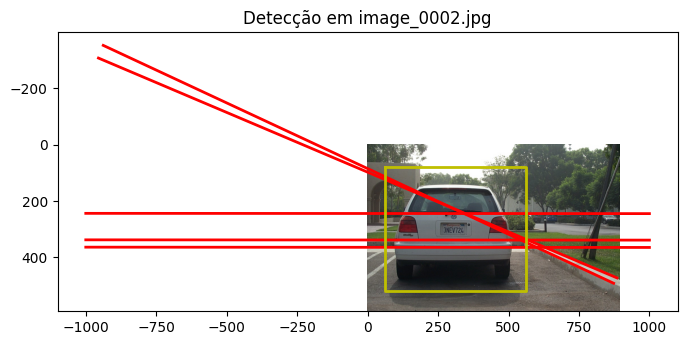


Processando image_0003.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


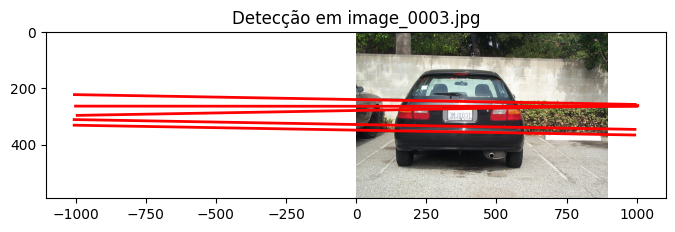


Processando image_0004.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


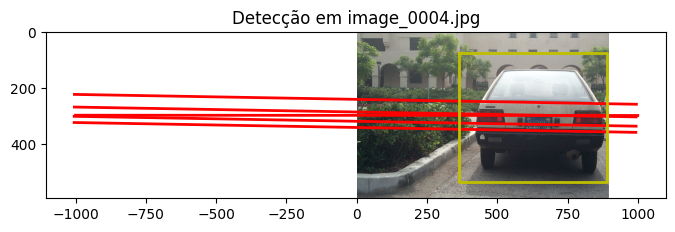


Processando image_0005.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


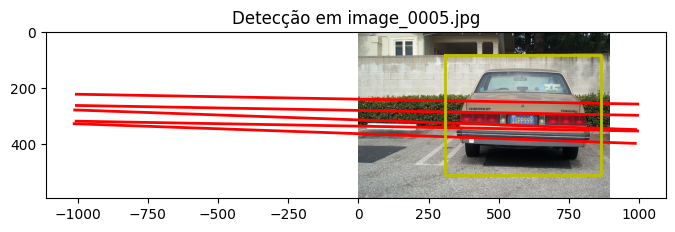


Processando image_0006.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


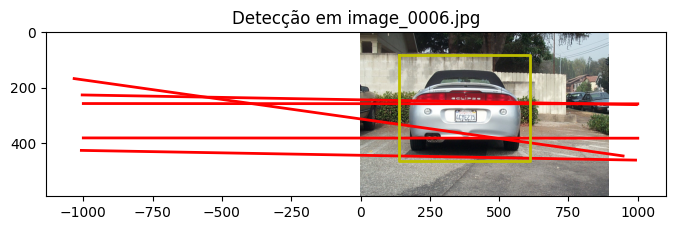


Processando image_0007.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


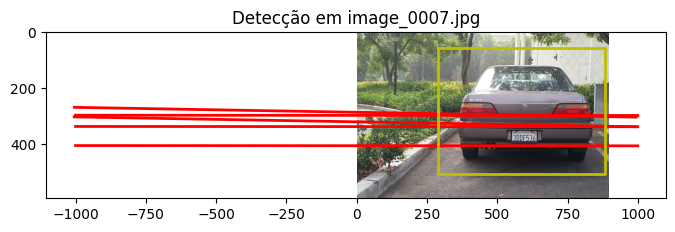


Processando image_0008.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


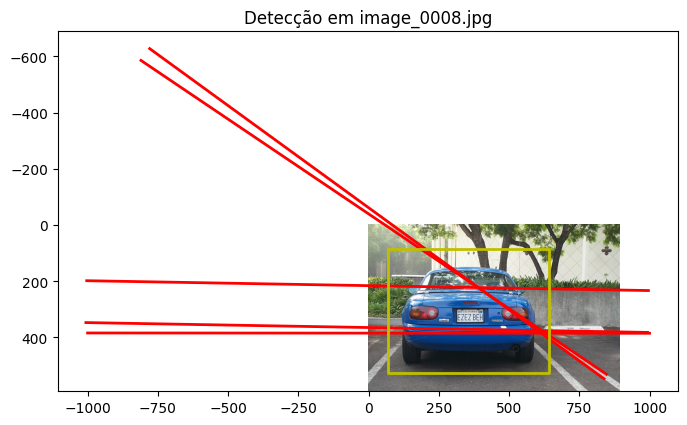


Processando image_0009.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


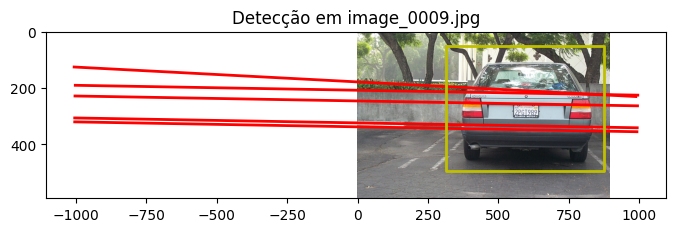


Processando image_0010.jpg...
  Linhas detectadas: 5
  Círculos detectados: 0
  Círculos dentro do retângulo manual: 0


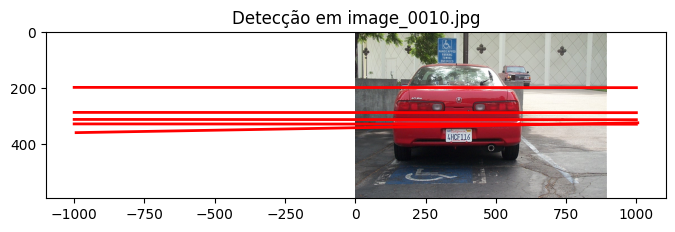

In [4]:
pasta_imagens = "imagens"
pasta_coordenadas = "coordenadas"

nomes_imagens = sorted(
    [arq for arq in os.listdir(pasta_imagens) if arq.lower().endswith(".jpg")]
)

for nome_imagem in nomes_imagens:
    print(f"\nProcessando {nome_imagem}...")
    caminho_imagem = os.path.join(pasta_imagens, nome_imagem)

    # Carrega imagem (convertendo para cinza para simplificar)
    imagem = io.imread(caminho_imagem)
    if len(imagem.shape) == 3:
        img_gray = color.rgb2gray(imagem)
    else:
        img_gray = imagem.astype(float) / 255.0

    # Detecta bordas (Canny)
    bordas = feature.canny(img_gray, sigma=2.0)

    # Transformada de Hough para Linhas
    hspace, angles, dists = hough_line(bordas)
    linha_peaks = hough_line_peaks(hspace, angles, dists, num_peaks=5)

    # Transformada de Hough para Círculos (exemplo para rodas)
    raios = np.arange(20, 60, 5)
    hough_res = [hough_circle(bordas, r) for r in raios]

    centros_detectados = []
    raios_detectados = []
    for i, radius in enumerate(raios):
        accums = hough_res[i]
        # Seleciona top 2 para cada raio
        from skimage.feature import peak_local_max

        peaks = peak_local_max(accums, num_peaks=2)
        for peak in peaks:
            centros_detectados.append((peak[0], peak[1]))  # (y, x)
            raios_detectados.append(radius)

    # Carrega coordenadas manuais
    nome_raiz = os.path.splitext(nome_imagem)[0]
    arq_txt = os.path.join(pasta_coordenadas, f"{nome_raiz}.txt")
    arq_json = os.path.join(pasta_coordenadas, f"{nome_raiz}.json")
    coords = carrega_coordenadas(arq_txt, arq_json)

    # Verificação de quantos círculos caem dentro do retângulo
    pontos_dentro = 0
    for (cy, cx), r in zip(centros_detectados, raios_detectados):
        # Ajuste: (cy, cx) -> (x, y) => (cx, cy)
        if dentro_do_retangulo(cx, cy, coords):
            pontos_dentro += 1

    # Exibe resultados gerais
    print(f"  Linhas detectadas: {len(linha_peaks[0])}")
    print(f"  Círculos detectados: {len(centros_detectados)}")
    print(f"  Círculos dentro do retângulo manual: {pontos_dentro}")

    # Plotagem para visualização
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(imagem)
    ax.set_title(f"Detecção em {nome_imagem}")

    # Desenha as retas detectadas
    from math import cos, sin

    for angle, dist in zip(linha_peaks[1], linha_peaks[2]):
        y0 = dist * sin(angle)
        x0 = dist * cos(angle)
        # Comprimento arbitrário para visualizar
        x1 = int(x0 + 1000 * (-sin(angle)))
        y1 = int(y0 + 1000 * (cos(angle)))
        x2 = int(x0 - 1000 * (-sin(angle)))
        y2 = int(y0 - 1000 * (cos(angle)))
        ax.plot((x1, x2), (y1, y2), "-r", linewidth=2)

    # Desenha os círculos detectados
    for (cy, cx), r in zip(centros_detectados, raios_detectados):
        circ_y, circ_x = circle_perimeter(int(cy), int(cx), int(r))
        # Círculo verde se está dentro da marcação, caso contrário vermelho
        if dentro_do_retangulo(cx, cy, coords):
            cor = (0, 1, 0)  # verde
        else:
            cor = (1, 0, 0)  # vermelho

        ax.plot(circ_x, circ_y, color=cor, linewidth=1)

    # Desenha o retângulo manual, se disponível
    if len(coords) == 4:
        xs = [p[0] for p in coords]
        ys = [p[1] for p in coords]
        min_x, max_x = min(xs), max(xs)
        min_y, max_y = min(ys), max(ys)
        # 4 pontos do retângulo para plot
        rect_x = [min_x, max_x, max_x, min_x, min_x]
        rect_y = [min_y, min_y, max_y, max_y, min_y]
        ax.plot(rect_x, rect_y, "-y", linewidth=2)

    plt.show()

### Observação

Este exemplo não garante a detecção perfeita do carro, pois trata-se de uma demonstração de como
poderíamos combinar transformadas de Hough e comparações geométricas básicas. A detecção real
poderia demandar processos de segmentação, fusão de características e outros métodos de processamento
de imagem tradicionais (sempre sem redes neurais, conforme exigido).